In [1]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=64,
    shuffle=True
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 161MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 23.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 86.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.13MB/s]


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(-1, 28*28))


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)


In [6]:
for epoch in range(3):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        b_size = real_imgs.size(0)

        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)

        # Generator training
        z = torch.randn(b_size, 100).to(device)
        fake_imgs = G(z)
        g_loss = criterion(D(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Discriminator training
        d_real_loss = criterion(D(real_imgs), real_labels)
        d_fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        d_loss = d_real_loss + d_fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/3] | Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")


Epoch [1/3] | Generator Loss: 4.0005, Discriminator Loss: 0.0473
Epoch [2/3] | Generator Loss: 4.9164, Discriminator Loss: 0.1032
Epoch [3/3] | Generator Loss: 3.8005, Discriminator Loss: 0.0756


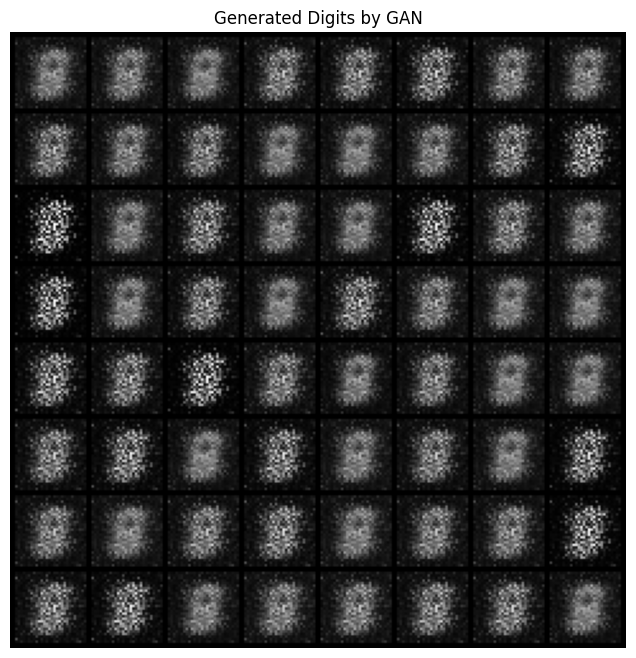

In [7]:
with torch.no_grad():
    z = torch.randn(64, 100).to(device)
    generated = G(z).cpu()
    grid = make_grid(generated, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title("Generated Digits by GAN")
    plt.show()
